In [1]:
import os, sys
sys.path.append("/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages")

In [2]:
from scipy.sparse import csr_matrix, eye, diags
from scipy.sparse.linalg import cg
from skimage.io import imread

import cv2
import matplotlib.pyplot as plt
import numpy as np

# Params

In [569]:
PATH_TO_DATA = '../../data'
grid_params = {'sigma_spatial': 5, 
               'sigma_luma': 4, 
               'sigma_chroma': 4}
solver_params = {'max_iter_bisto': 10,
                 'max_iter_cg': 25,
                 'lambda': 128}

# Data

In [4]:
def read_images(file_path, file_names):
    """Read images in a same folder
    
    Params:
        file_path (str): folder path
        file_names (list): list of file names
        
    Returns:
        imgs (list): list of images
    """
    
    imgs = [imread(os.path.join(file_path, name)) for name in file_names]
    
    print("Load %d images!" % len(imgs))

    return imgs

In [5]:
def plot_images(imgs, names):
    """Plot images vertically
    
    Params:
        imgs(list): list of images
        names(list): list of figure titles
    """
    
    n = len(imgs)
    plt.figure(figsize = (20 * n, 20))
    
    for i in range(n):
        plt.subplot(n, 1, i + 1)
        plt.imshow(imgs[i])
        plt.title(names[i])

    plt.show()

# Color Convert

In [6]:
# COPIED FROM https://github.com/poolio/bilateral_solver

RGB_TO_YUV = np.array([
    [ 0.299,     0.587,     0.114],
    [-0.168736, -0.331264,  0.5],
    [ 0.5,      -0.418688, -0.081312]])
YUV_TO_RGB = np.array([
    [1.0,  0.0,      1.402],
    [1.0, -0.34414, -0.71414],
    [1.0,  1.772,    0.0]])
YUV_OFFSET = np.array([0, 128.0, 128.0]).reshape(1, 1, -1)

def rgb2yuv(im):
    return np.tensordot(im, RGB_TO_YUV, ([2], [1])) + YUV_OFFSET

def yuv2rgb(im):
    return np.tensordot(im.astype(float) - YUV_OFFSET, YUV_TO_RGB, ([2], [1]))

# Bilateral Grid

In [154]:
def build_W(yuv_im, param):
    """Create the grid coordinates and the blur matrix
    
    Params:
        yum_im (np.array): reference image in YUV color space
        param (dict): provide parameters
        
    Returns:
        S (np.array): of size num_voxels x num_verticals
        B_ (np.array): of size num_verticals x num_verticals
    
    """

    n_row, n_col, _ = yuv_im.shape
    nb_pixels = n_row * n_col
    
    # [1, 255, 255^2, 255^3, 255^4] -> [col, row, y, u, v]
    hashing_vector = np.zeros(5)
    for i in range(5):
        hashing_vector[i] = 255 ** i

    # a dict from hash number to index
    hashed_coords = {}
    
    vertical_idx = 0
    pixel_idx = 0
    splat_idxs = np.zeros(nb_pixels)
    
    for col_idx in range(n_col):
        for row_idx in range(n_row):
            coord = np.zeros(5)
            coord[0] = row_idx // param['sigma_spatial']
            coord[1] = col_idx // param['sigma_spatial']
            coord[2] = yuv_im[row_idx, col_idx, 0] // param['sigma_luma']
            coord[3] = yuv_im[row_idx, col_idx, 1] // param['sigma_chroma']
            coord[4] = yuv_im[row_idx, col_idx, 2] // param['sigma_chroma']
            
            hashed_coord = sum([coord[i] * hashing_vector[i] for i in range(5)])
            
            if hashed_coord in hashed_coords:
                splat_idxs[pixel_idx] = hashed_coords[hashed_coord]
            else:
                hashed_coords[hashed_coord] = vertical_idx
                splat_idxs[pixel_idx] = vertical_idx
                vertical_idx += 1
            
            pixel_idx += 1
            
    n_vertices = len(hashed_coords)
    
    # (data, (row_idx, col_idx))
    S = csr_matrix((np.ones(nb_pixels), (splat_idxs.astype(int), np.arange(nb_pixels))))
    B_ = eye(n_vertices) * 10 # 2 * 5
    
    func_mask = np.vectorize(lambda x: x in hashed_coords)
    func_coords = np.vectorize(lambda x: hashed_coords[x])
    
    # Convolution [1, 2, 1] ^ 5
    for offset in (-1, 1):
        for i in range(5):
            offset_hashed_coord = offset * hashing_vector[i]
            centers = np.array(list(hashed_coords.keys()))
            neighbors = centers + offset_hashed_coord
            mask = func_mask(neighbors)
            
            if mask.sum() > 0:
                coords_centers = func_coords(centers[mask])
                coords_neighbors = func_coords(neighbors[mask])

                nb_neighbors = len(coords_centers)
                B_temp = csr_matrix((np.ones(nb_neighbors), (coords_centers, coords_neighbors)), shape = (n_vertices, n_vertices))
                B_ += B_temp
            
    return S, B_

In [239]:
def init_solution(S, confidence, target):
    """Naive solution by performing convolution
    
    Params:
        S: matrix of grid_coordinates
        confidence: confidence map
        target: target map
        
    Returns:
        x_hat: solution in coordinate
        y_hat: solution in bilateral space
    """

    s_ct = S.dot(confidence * target)
    s_c = np.clip(S.dot(confidence), 1e-8, None)
    
    y_hat = s_ct / s_c
    x_hat = S.T.dot(y_hat).reshape(confidence.shape)
    
    return x_hat, y_hat

# Bilateral Solver

In [9]:
def bistochastization(S, B_, max_iter = 10):
    """Make all rows and columns have the same mean value
    
    Params:
        S: grid_coordinates
        B_: blur matrix
        max_iter: number of iterations
        
    Returns:
        Dn (csr matrix)
        Dm (csr matrix) 
    """
    
    # S.sum(1)
    m = S.dot(np.ones(S.shape[1]))
    n = np.ones(S.shape[0])
    
    for _ in range(max_iter):
        num = n * m
        den = B_.dot(n)
        n = np.sqrt(np.divide(num, den))
    
    # Correct m to satisfy the assumption of bistochastization regardless
    # of how many iterations have been run.
    m = n * (B_.dot(n))

    return diags(n, 0, format = 'csr'), diags(m, 0, format = 'csr')

In [10]:
def build_A(S, B_, D_n, D_m, conf, lamb):
    """Calculate A
    
    Params:
        S: grid_coordinates
        B_: blur matrix
        Dn: bistochastic matrix
        Dm: bistochastic matrix
        conf: confidence map
        lamb: coefficient for bilateral term
        
    Returns:
        A: of size num_voxels x num_voxels  
    """

    A = lamb * (D_m - D_n.dot(B_.dot(D_n))) + diags(np.squeeze(S.dot(conf.reshape((-1, 1)))), format = 'csr')
    
    return A

In [11]:
def build_b(S, conf, target):
    """Calculate b
    
    Params:
        S: grid_coordinates
        conf: confidence map
        target: target map
        
    Returns:
        b: of size num_voxels x 1
    """
    
    dot_prod = (conf * target).reshape((-1, 1))
    
    return S.dot(dot_prod)

In [413]:
def naive_preconditioner(A):
    """Jacobi preconditioner for A
    
    Params:
        A: of size num_voxels x num_voxels
        
    Returns:
        M_inv: jacobi preconditioner
    """
    
    M_inv = diags(1. / np.clip(A.diagonal(), 1e-6, None), 0)
    
    return M_inv

In [13]:
def cg_solver(A, b, M_inv, y0, max_iter = 50):
    """Solve Ay = b
    
    Params:
        A: of size num_voxels x num_voxels
        b: of size num_voxels x 1
        M_inv: preconditioner for A
        y0: initial solution
        max_iter: maximum number of iterations
        
    Return:    
        y: solution
    """
    
    y = cg(A, b, M = M_inv, maxiter = max_iter, x0 = y0)
    
    return y

# Oracle

In [14]:
def bilateral_grid(ref, scaled_confidence, scaled_target, grid_params):
    """Oracle for bilateral grid
    
    Params:
        ref: reference image in RGB color space
        scaled_confidence: scaled confidence map
        scaled_target: scaled target map
        grid_params: parameters for the oracle
        
    Returns:
        S: grid coordinate
        B_: blur matrix
        x0: naive solution in coordinate space
        y0: naive solution in bilateral space
    """
    
    print("Convert image to YUV space...")
    ref_yuv = rgb2yuv(ref)
    print("Image size: ", ref_yuv.shape)
    print("Min pixel value: ", ref_yuv.min((0, 1)))
    print("Max pixel value: ", ref_yuv.max((0, 1)))
    
    print("\nBuild S and B...")
    S, B_ = build_W(ref_yuv, grid_params)
    
    print("\nCalculate solution...")
    x0, y0 = init_solution(S, scaled_confidence, scaled_target)
    print("\nFinish!")
    
    results = {'S': S, 'B_': B_, 'x0': x0, 'y0': y0}
    
    return results

In [606]:
def bilateral_solver(scaled_confidence, scaled_target, grid_results, img_shape, solver_params):
    """Oracle for bilateral solver
    
    Params:
        scaled_confidence: scaled confidence map
        scaled_target: scaled target map
        grid_results: solutions from bilateral grid
        img_shape: shape of the output map
        solver_params: parameters for the oracle
    
    Returns:
        x: final solution in coordinate space
    """
    
    S, B_, y0 = grid_results['S'], grid_results['B_'], grid_results['y0']
    
    print("Bistochastization S and B...")
    D_n, D_m = bistochastization(S, B_, solver_params['max_iter_bisto'])
    
    print("\nCalculate A and b...")
    A = build_A(S, B_, D_n, D_m, scaled_confidence, solver_params["lambda"])
    b = b = build_b(S, scaled_confidence, scaled_target)
    
    print("\nPreconditionning...")
    M_inv = naive_preconditioner(A)
    
    print("\nSolve Ay = b...")
    y, flag = cg_solver(A, b, M_inv, y0, solver_params['max_iter_cg'])
    
    assert(flag >= 0), "Conjugate gradient solve failed!"
    
    print("\nCalculate x...")
    x = S.T.dot(y).reshape(img_shape).T
    print("\nFinish!")
    
    return x

# Experiments

In [635]:
name = "monaco"
reference, target = read_images(PATH_TO_DATA, [name + '/reference.bmp',  name + '/target.bmp'])
confidence = np.apply_along_axis(lambda x: len(set(x)) > 2, -1, target)

if len(reference.shape) == 2:
    reference = np.repeat(reference[:, :, np.newaxis], 3, axis = 2)
    
print("Image Size:", reference.shape)

Load 2 images!
Image Size: (299, 399, 3)


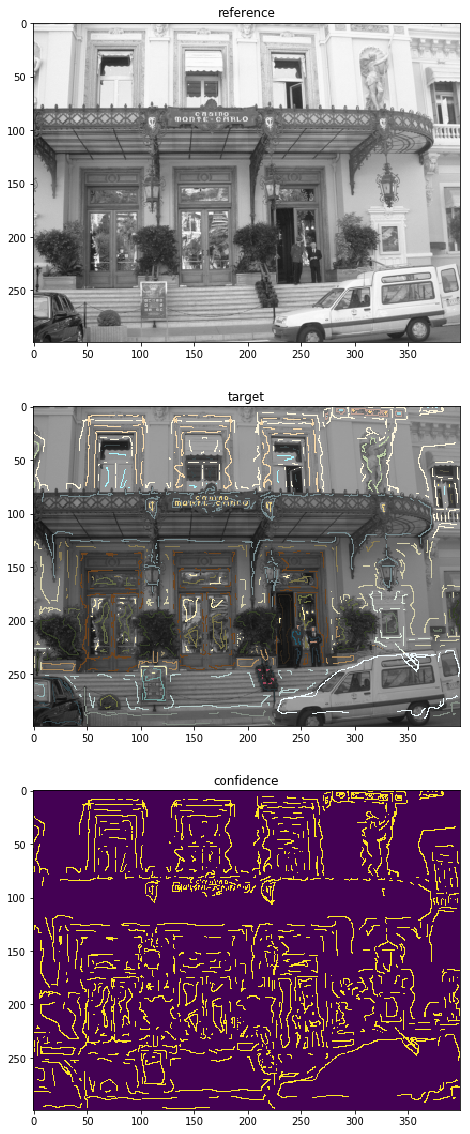

In [636]:
plot_images([reference, target, confidence], 
            ['reference', 'target', 'confidence'])

In [637]:
target_uv = rgb2yuv(target)
target_u, target_v = target_uv[:, :, 1], target_uv[:, :, 2]

scaled_t1 = target_u.T.reshape(-1, 1).astype(np.double) - 128
scaled_t2 = target_v.T.reshape(-1, 1).astype(np.double) - 128
scaled_c = confidence.T.reshape(-1, 1).astype(np.double)

In [638]:
grid_results_1 = bilateral_grid(reference, scaled_c, scaled_t1, grid_params)
grid_results_2 = bilateral_grid(reference, scaled_c, scaled_t2, grid_params)

Convert image to YUV space...
Image size:  (299, 399, 3)
Min pixel value:  [ 17. 128. 128.]
Max pixel value:  [252. 128. 128.]

Build S and B...

Calculate solution...

Finish!
Convert image to YUV space...
Image size:  (299, 399, 3)
Min pixel value:  [ 17. 128. 128.]
Max pixel value:  [252. 128. 128.]

Build S and B...

Calculate solution...

Finish!


In [639]:
out_shape = reference.shape[:2][::-1]
u = bilateral_solver(scaled_c, scaled_t1, grid_results_1, out_shape, solver_params)
v = bilateral_solver(scaled_c, scaled_t2, grid_results_2, out_shape, solver_params)

Bistochastization S and B...

Calculate A and b...

Preconditionning...

Solve Ay = b...

Calculate x...

Finish!
Bistochastization S and B...

Calculate A and b...

Preconditionning...

Solve Ay = b...

Calculate x...

Finish!


In [640]:
ref_yuv = rgb2yuv(reference)
image_fgs = yuv2rgb((np.stack((ref_yuv[:, :, 0], u + 128 , v + 128), axis = -1)))
image_fgs = image_fgs - image_fgs.min((0, 1))
image_fgs = (image_fgs / image_fgs.max((0, 1)) * 255).astype(np.uint8)

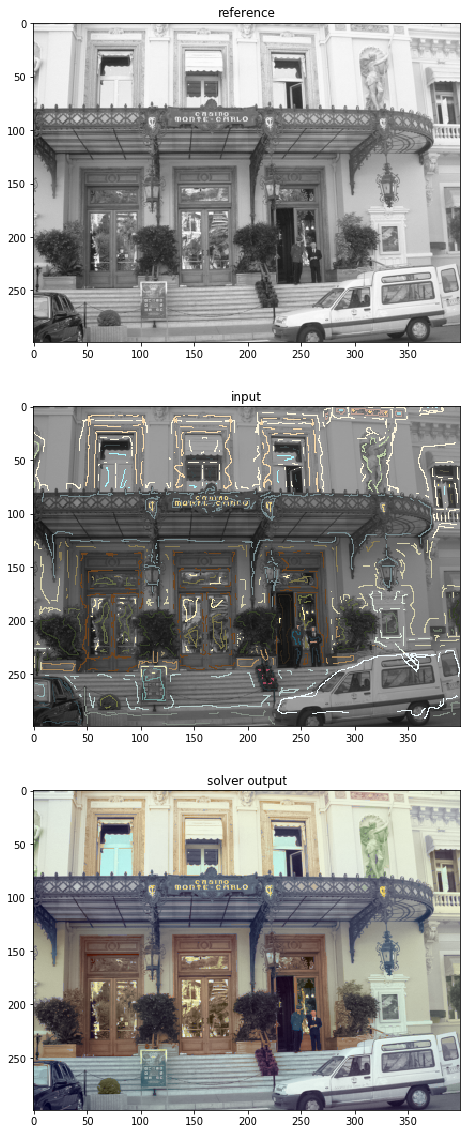

In [641]:
plot_images([reference, target, image_fgs], 
            ['reference', 'input', 'solver output'])

In [642]:
ref = Image.fromarray(reference)
ref.save("../results/" + name + "_ref.png","PNG")

targ = Image.fromarray(target)
targ.save("../results/" + name + "_targ.png","PNG")

res = Image.fromarray(image_fgs)
res.save("../results/" + name + "_result.png","PNG")